# checking TF-IDF word with removing stopwords

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# 下载必要的NLTK数据
nltk.download('stopwords')
nltk.download('wordnet')

# 定义自定义停用词
# 一般性词汇
general_stopwords = {
    'one', 'would', 'could', 'also', 'must', 'wa', 'ha', 'see',
    'think', 'make', 'made', 'like', 'said', 'new', 'use',
    'may', 'might', 'shall', 'get', 'got', 'doe', 'do', 'did',
    'say', 'way', 'day', 'time', 'year', 'week',
    'take', 'give', 'call', 'look', 'come', 'go',
    'many', 'much', 'several', 'other', 'another',
    'even', 'still', 'back', 'well', 'way', 'thing',
    'seem', 'rather', 'sure', 'likely', 'unlikely',
    'although', 'though', 'per','product','including','number',
    'include','using','item','standard','rule','clearly','used',
    'issue','public'
}

# 代词
pronouns = {
    'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves',
    'this', 'that', 'these', 'those',
    'he', 'him', 'his', 'himself',
    'she', 'her', 'hers', 'herself'
}

# 投诉相关常用词（这些词在投诉语境中太常见，不具有区分性）
complaint_common = {
    'complaint', 'complaints', 'complainant', 'complainants',
    'advertisement', 'advertisements', 'advertising', 'advertiser', 'advertisers',
    'ad', 'ads', 'advert', 'adverts',
    'concerned', 'concerning', 'concerns',
    'believe', 'believes', 'believed',
    'claim', 'claims', 'claimed',
    'content', 'contents',
    'page', 'pages',
    'show', 'shows', 'shown',
    'view', 'views', 'viewed'
}

# 人物和地点相关
person_location = {
    'man', 'woman', 'person', 'people',
    'child', 'children', 'young',
    'consumer', 'consumers',
    'nz', 'zealand', 'zealand',
    'board', 'authority'
}

# 再添加一些特殊情况
additional_words = {
    'act', 'code', 'inappropriate', 'state',
    'promotion', 'service', 'services'
}
# 合并所有停用词
custom_stopwords = general_stopwords.union(
    pronouns,
    complaint_common,
    person_location,
    additional_words
)

def clean_text(text):
    """基础文本清理"""
    if pd.isna(text):
        return ""
    
    # 转换为小写
    text = text.lower()
    
    # 统一COVID-19的各种写法
    text = re.sub(r'covid[-\s]?19', 'covid19', text, flags=re.IGNORECASE)  # 处理 covid-19, covid 19
    text = re.sub(r'covid(?!19)', 'covid19', text, flags=re.IGNORECASE)    # 处理单独的 covid
    text = re.sub(r'coronavirus', 'covid19', text, flags=re.IGNORECASE)     # 将 coronavirus 也统一
    
    # 移除特殊字符和多余的空格
    text = re.sub(r'\|', ' ', text)  # 移除竖线
    text = re.sub(r'\s+', ' ', text)  # 移除多余空格
    text = re.sub(r'http\S+|www.\S+', '', text)  # 移除URL
    text = re.sub(r'\S+@\S+', '', text)  # 移除邮件地址
    
    # 移除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text.strip()

def lemmatize_text(text):
    '''词性还原'''
    if pd.isna(text):
        return ""
    
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

def remove_stopwords(text):
    """移除NLTK停用词和自定义停用词"""
    if pd.isna(text):
        return ""
    
    # 合并NLTK停用词和自定义停用词
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

def perform_tfidf_analysis(texts, max_features=1000):
    """
    对文本数据进行TF-IDF分析
    
    参数:
    texts: 文本列表或Series
    max_features: 保留的最大特征数量
    
    返回:
    results_df: 包含词语及其TF-IDF分数的DataFrame
    tfidf_matrix: TF-IDF特征矩阵
    feature_names: 特征名称列表
    """
    # 预处理文本
    processed_texts = []

    for text in texts:
        # 应用清理和停用词移除
        cleaned_text = clean_text(text)
        lemmatized_text = lemmatize_text(cleaned_text)
        processed_text = remove_stopwords(lemmatized_text)
        processed_texts.append(processed_text)
    
    # 初始化TF-IDF向量化器
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 1),  # 只使用单个词
        min_df=2,  # 最小文档频率
        stop_words = list(custom_stopwords)
    )
    
    # 转换文本数据
    tfidf_matrix = tfidf.fit_transform(processed_texts)
    
    # 获取特征名称（词语）
    feature_names = tfidf.get_feature_names_out()
    
    # 计算每个词的平均TF-IDF分数
    avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        'word': feature_names,
        'avg_tfidf_score': avg_tfidf
    })
    
    # 按TF-IDF分数降序排序
    results_df = results_df.sort_values('avg_tfidf_score', ascending=False)
    results_df = results_df.reset_index(drop=True)
    
    return results_df, tfidf_matrix, feature_names

# 主程序示例
if __name__ == "__main__":
    # 读取数据
    df = pd.read_csv('/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/combination_excel_withoutnull_labeled.csv')
    
    # 如果您想要在停用词中排除covid19，可以在custom_stopwords中添加以下代码：
    keep_words = {'covid19'}  # 需要保留的词
    custom_stopwords = custom_stopwords - keep_words  # 从停用词中移除需要保留的词

    # 执行TF-IDF分析
    results_df, tfidf_matrix, feature_names = perform_tfidf_analysis(
        df['complaints'],
        max_features=1000
    )
    
    # 打印前20个最重要的词
    print("\n前20个最重要的词及其TF-IDF分数:")
    print(results_df.head(20))
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niwenyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/niwenyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



前20个最重要的词及其TF-IDF分数:
           word  avg_tfidf_score
0    misleading         0.028252
1        health         0.021917
2         covid         0.019222
3       website         0.017765
4       alcohol         0.017301
5          life         0.014624
6            19         0.013830
7        breach         0.013288
8        uphold         0.012904
9     offensive         0.012725
10      vaccine         0.012686
11  information         0.012481
12    statement         0.012151
13        false         0.012096
14        image         0.011943
15       social         0.011739
16    billboard         0.011634
17         find         0.011051
18         free         0.010945
19          two         0.010744


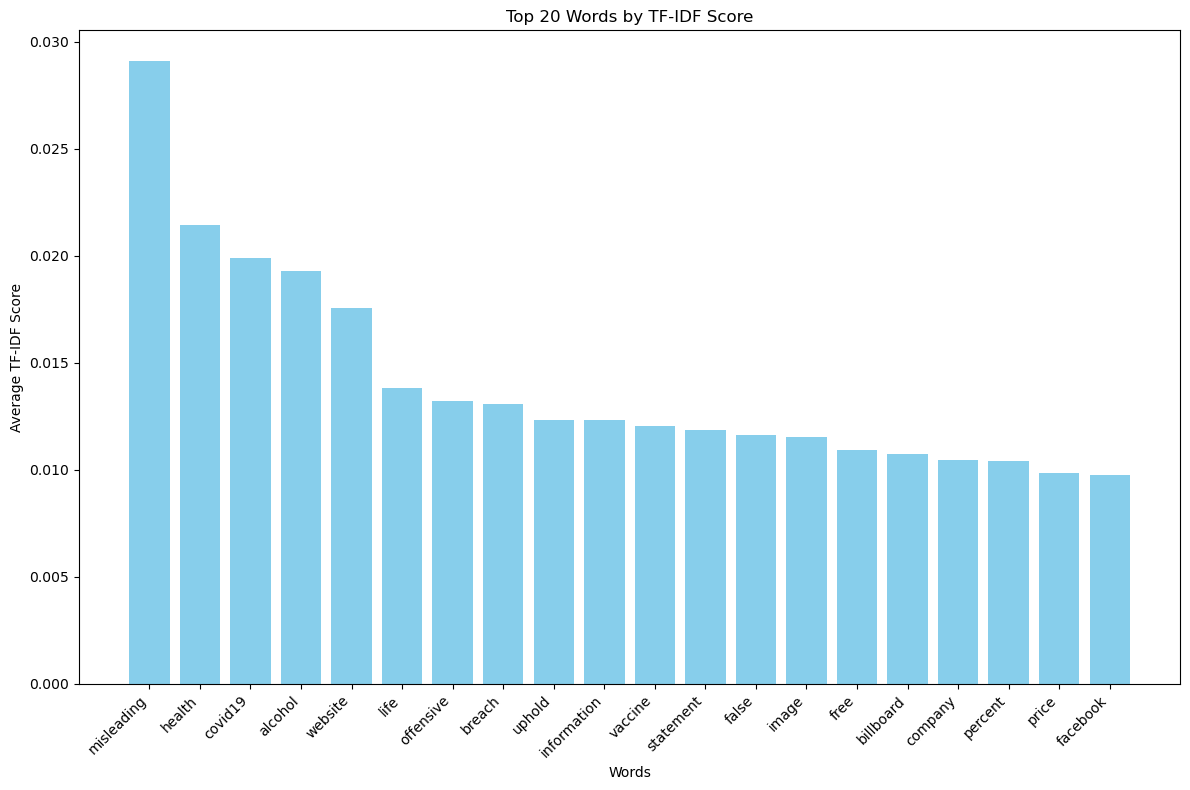

In [3]:
import matplotlib.pyplot as plt

def plot_tfidf_scores(results_df, top_n=20):
    """
    Plots a bar chart of the top_n words by their TF-IDF scores.
    
    Args:
    results_df (DataFrame): DataFrame containing the words and their average TF-IDF scores.
    top_n (int): Number of top words to plot.
    """
    # Sort the DataFrame by TF-IDF scores in descending order
    sorted_df = results_df.sort_values('avg_tfidf_score', ascending=False).head(top_n)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.bar(sorted_df['word'], sorted_df['avg_tfidf_score'], color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Average TF-IDF Score')
    plt.title('Top {} Words by TF-IDF Score'.format(top_n))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage with your TF-IDF results DataFrame
if __name__ == "__main__":
    # Assume 'results_df' is your DataFrame from the TF-IDF analysis containing columns 'word' and 'avg_tfidf_score'
    plot_tfidf_scores(results_df)


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import logging
from pathlib import Path

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# 下载必要的NLTK数据
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
except Exception as e:
    logging.warning(f"NLTK数据下载失败: {e}")

# 初始化lemmatizer（全局使用）
lemmatizer = WordNetLemmatizer()

# 定义自定义停用词
# 一般性词汇
general_stopwords = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'would', 'could', 'also', 'must', 'wa', 'ha', 'see',
    'think', 'make', 'made', 'like', 'said', 'new', 'use',
    'may', 'might', 'shall', 'get', 'got', 'doe', 'do', 'did',
    'say', 'way', 'day', 'time', 'year', 'week',
    'take', 'give', 'call', 'look', 'come', 'go', 'find',
    'many', 'much', 'several', 'other', 'another',
    'even', 'still', 'back', 'well', 'way', 'thing',
    'seem', 'rather', 'sure', 'likely', 'unlikely',
    'although', 'though', 'per', 'product', 'including', 'number',
    'include', 'using', 'item', 'standard', 'rule', 'clearly', 'used',
    'issue', 'public', 'first', 'second', 'third', 'next', 'last','without'
}

# 代词
pronouns = {
    'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves',
    'this', 'that', 'these', 'those',
    'he', 'him', 'his', 'himself',
    'she', 'her', 'hers', 'herself'
}

# 投诉相关常用词
complaint_common = {
    'complaint', 'complaints', 'complainant', 'complainants',
    'advertisement', 'advertisements', 'advertising', 'advertiser', 'advertisers',
    'ad', 'ads', 'advert', 'adverts',
    'concerned', 'concerning', 'concerns',
    'believe', 'believes', 'believed',
    'claim', 'claims', 'claimed',
    'content', 'contents',
    'page', 'pages',
    'show', 'shows', 'shown',
    'view', 'views', 'viewed'
}

# 人物和地点相关
person_location = {
    'man', 'woman', 'person', 'people',
    'child', 'children', 'young',
    'consumer', 'consumers',
    'nz', 'zealand', 'zealand',
    'board', 'authority'
}

# 特殊情况
additional_words = {
    'act', 'code', 'inappropriate', 'state',
    'promotion', 'service', 'services',
    'find', 'found', 'finding',
    'number', 'numbernumber'
}

# 合并所有停用词
custom_stopwords = general_stopwords.union(
    pronouns,
    complaint_common,
    person_location,
    additional_words
)

# 定义需要保留的词
keep_words = {'covid19', 'website', 'socialmedia', 'facebook', 'instagram', 'twitter'}
# 从停用词中移除需要保留的词
custom_stopwords = custom_stopwords - keep_words

# 词语替换映射
word_replacements = {
    r'covid[-\s]?19|coronavirus|covid(?!19)': 'covid19',
    r'web\s*site|web\s*page': 'website',
    r'social\s*media': 'socialmedia',
    r'face\s*book': 'facebook',
    r'insta\s*gram': 'instagram',
    r'\b\d+\s*percent\b|\b\d+%': 'percent',
    r'number+': 'number',  # 处理重复的number
}

def clean_text(text):
    """
    文本清理函数
    - 统一词语变体
    - 移除特殊字符
    - 处理数字和标点符号
    """
    if pd.isna(text):
        return ""
    
    # 转换为小写
    text = text.lower()
    
    # 应用词语替换
    for pattern, replacement in word_replacements.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    # 处理特殊字符和格式
    text = re.sub(r'\s+', ' ', text)               # 多个空格替换为单个
    text = re.sub(r'\|', ' ', text)                # 处理竖线
    text = re.sub(r'http\S+|www.\S+', '', text)    # 移除URL
    text = re.sub(r'\S+@\S+', '', text)            # 移除邮件
    
    # 完全移除独立的数字
    text = re.sub(r'\b\d+\b', '', text)
    
    # 移除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text.strip()

def lemmatize_text(text):
    """词形还原"""
    if pd.isna(text):
        return ""
    
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

def remove_stopwords(text):
    """移除停用词"""
    if pd.isna(text):
        return ""
    
    # 合并NLTK停用词和自定义停用词
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

def perform_tfidf_analysis(texts, max_features=1000):
    """
    执行TF-IDF分析
    """
    if len(texts) == 0:
        raise ValueError("输入文本列表为空")
    if max_features <= 0:
        raise ValueError("max_features必须为正数")
    
    logging.info(f"开始处理{len(texts)}条文本...")
    processed_texts = []
    
    for i, text in enumerate(texts):
        if i % 100 == 0:
            logging.info(f"已处理 {i}/{len(texts)} 条文本...")
        
        cleaned_text = clean_text(text)
        lemmatized_text = lemmatize_text(cleaned_text)
        processed_text = remove_stopwords(lemmatized_text)
        processed_texts.append(processed_text)
    
    logging.info("开始TF-IDF转换...")
    
    # 初始化TF-IDF向量化器
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 1),
        min_df=2
    )
    
    # 转换文本数据
    tfidf_matrix = tfidf.fit_transform(processed_texts)
    feature_names = tfidf.get_feature_names_out()
    
    # 计算每个词的平均TF-IDF分数
    avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        'word': feature_names,
        'avg_tfidf_score': avg_tfidf
    })
    
    # 按TF-IDF分数降序排序
    results_df = results_df.sort_values('avg_tfidf_score', ascending=False)
    results_df = results_df.reset_index(drop=True)
    
    logging.info("TF-IDF分析完成")
    
    return results_df, tfidf_matrix, feature_names

def save_results(results_df, output_dir='results'):
    """保存结果到文件"""
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # 保存TF-IDF结果
    results_path = output_path / 'tfidf_results.csv'
    results_df.to_csv(results_path, index=False)
    logging.info(f"结果已保存至: {results_path}")

def analyze_top_words(results_df, n=20):
    """分析并打印前N个高频词的详细信息"""
    print(f"\n前{n}个最重要词的分析:")
    print("-" * 50)
    for idx, row in results_df.head(n).iterrows():
        print(f"{idx+1:2d}. {row['word']:<15} (得分: {row['avg_tfidf_score']:.6f})")

# 主程序
if __name__ == "__main__":
    try:
        # 读取数据
        file_path = '/Users/niwenyu/Desktop/OCR_PDF_EXTRACT/combination_excel_withoutnull_labeled.csv'
        logging.info(f"读取数据文件: {file_path}")
        df = pd.read_csv(file_path)
        
        # 执行TF-IDF分析
        results_df, tfidf_matrix, feature_names = perform_tfidf_analysis(
            df['complaints'],
            max_features=1000
        )
        
        # 分析并显示结果
        analyze_top_words(results_df, n=20)
        
        # 保存结果
        save_results(results_df)
        
    except Exception as e:
        logging.error(f"处理过程中出现错误: {e}")
        raise

2025-01-19 10:55:48,748 - INFO - 读取数据文件: /Users/niwenyu/Desktop/OCR_PDF_EXTRACT/combination_excel_withoutnull_labeled.csv
2025-01-19 10:55:48,766 - INFO - 开始处理1875条文本...
2025-01-19 10:55:48,767 - INFO - 已处理 0/1875 条文本...
2025-01-19 10:55:50,402 - INFO - 已处理 100/1875 条文本...
2025-01-19 10:55:50,439 - INFO - 已处理 200/1875 条文本...
2025-01-19 10:55:50,476 - INFO - 已处理 300/1875 条文本...
2025-01-19 10:55:50,508 - INFO - 已处理 400/1875 条文本...
2025-01-19 10:55:50,545 - INFO - 已处理 500/1875 条文本...
2025-01-19 10:55:50,571 - INFO - 已处理 600/1875 条文本...
2025-01-19 10:55:50,602 - INFO - 已处理 700/1875 条文本...
2025-01-19 10:55:50,631 - INFO - 已处理 800/1875 条文本...
2025-01-19 10:55:50,661 - INFO - 已处理 900/1875 条文本...
2025-01-19 10:55:50,696 - INFO - 已处理 1000/1875 条文本...
2025-01-19 10:55:50,730 - INFO - 已处理 1100/1875 条文本...
2025-01-19 10:55:50,761 - INFO - 已处理 1200/1875 条文本...
2025-01-19 10:55:50,796 - INFO - 已处理 1300/1875 条文本...
2025-01-19 10:55:50,823 - INFO - 已处理 1400/1875 条文本...
2025-01-19 10:55:50,850 - INFO -


前20个最重要词的分析:
--------------------------------------------------
 1. misleading      (得分: 0.029080)
 2. health          (得分: 0.021459)
 3. covid19         (得分: 0.019885)
 4. alcohol         (得分: 0.019290)
 5. website         (得分: 0.017570)
 6. life            (得分: 0.013847)
 7. offensive       (得分: 0.013229)
 8. breach          (得分: 0.013075)
 9. uphold          (得分: 0.012334)
10. information     (得分: 0.012332)
11. vaccine         (得分: 0.012034)
12. statement       (得分: 0.011855)
13. false           (得分: 0.011635)
14. image           (得分: 0.011539)
15. free            (得分: 0.010917)
16. billboard       (得分: 0.010758)
17. company         (得分: 0.010473)
18. percent         (得分: 0.010406)
19. price           (得分: 0.009855)
20. facebook        (得分: 0.009744)


In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import logging

logging.basicConfig(level=logging.INFO)

class ImprovedAdComplaintFeatures:
    def __init__(self):
        # 重新设计的标签词典
        self.label_dict = {
            'misleading': {  # 标签1
                'primary': [
                    'misleading', 'false', 'deceptive', 'untrue', 'fake',
                    'misrepresent', 'incorrect', 'inaccurate', 'lie', 'dishonest',
                    'fraud', 'scam', 'trick', 'deceit'
                ],
                'phrases': [
                    'not true', 'false claim', 'misleading information',
                    'wrong information', 'fake news', 'false advertising',
                    'no evidence', 'no proof', 'misleading claim'
                ]
            },
            'social_responsibility': {  # 标签2
                'primary': [
                    'alcohol', 'drinking', 'gambling', 'tobacco', 'smoking',
                    'drug', 'addiction', 'betting', 'unhealthy', 'harmful'
                ],
                'phrases': [
                    'public health', 'social impact', 'community concern',
                    'negative influence', 'harmful effect', 'health risk',
                    'bad influence', 'irresponsible marketing'
                ]
            },
            'placement': {  # 标签3
                'primary': [
                    'location', 'place', 'position', 'display', 'billboard',
                    'screen', 'visible', 'distance', 'site', 'street', 'road'
                ],
                'phrases': [
                    'near school', 'close to', 'in front of', 'next to',
                    'too close', 'wrong place', 'inappropriate location',
                    'residential area', 'public space', 'busy road'
                ]
            },
            'children': {  # 标签4
                'primary': [
                    'child', 'children', 'kid', 'minor', 'young', 'youth',
                    'teen', 'teenage', 'adolescent', 'student', 'parent',
                    'school', 'playground', 'infant', 'baby'
                ],
                'phrases': [
                    'target children', 'aimed at children', 'appeal to children',
                    'child safety', 'protect children', 'school area',
                    'young people', 'young audience', 'underage'
                ]
            },
            'taste_decency': {  # 标签5
                'primary': [
                    'offensive', 'inappropriate', 'vulgar', 'explicit', 'disturbing',
                    'violent', 'sexual', 'graphic', 'crude', 'rude', 'tasteless',
                    'indecent', 'obscene', 'improper'
                ],
                'phrases': [
                    'too graphic', 'not appropriate', 'bad taste',
                    'offensive content', 'inappropriate content',
                    'sexual content', 'violent content', 'disturbing image'
                ]
            }
        }

        # 情感标记词典
        self.emotion_words = {
            'strong_negative': [
                'very', 'extremely', 'absolutely', 'totally', 'completely',
                'highly', 'seriously', 'strongly', 'deeply', 'gravely',
                'outrageous', 'unacceptable', 'inappropriate', 'disgusting'
            ],
            'concern': [
                'worry', 'concern', 'afraid', 'fear', 'alarming',
                'dangerous', 'risky', 'threat', 'problem', 'issue',
                'serious', 'severe', 'significant'
            ]
        }
        
    def clean_text(self, text):
        """改进的文本清理，保留更多有意义的标点和格式"""
        text = str(text).lower()
        # 保留更多标点符号和格式特征
        text = re.sub(r'[^a-z0-9\s!?.,-:;\'"()]', ' ', text)
        # 规范化空白字符
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def extract_phrase_features(self, text, phrases):
        """提取短语特征"""
        count = 0
        for phrase in phrases:
            count += text.count(phrase)
        return count
    
    def extract_label_features(self, text):
        """提取标签相关特征"""
        text = self.clean_text(text)
        words = text.split()
        total_words = len(words) if words else 1
        
        features = {}
        
        for label, word_sets in self.label_dict.items():
            # 单词级别特征
            primary_count = sum(word in text for word in word_sets['primary'])
            # 短语级别特征
            phrase_count = self.extract_phrase_features(text, word_sets['phrases'])
            
            features.update({
                f'{label}_primary_count': primary_count,
                f'{label}_phrase_count': phrase_count,
                f'{label}_total_count': primary_count + phrase_count,
                f'{label}_density': (primary_count + phrase_count) / total_words,
                f'{label}_phrase_ratio': phrase_count / (primary_count + phrase_count + 1e-10)
            })
        
        return features

    def extract_emotion_features(self, text):
        """提取情感特征"""
        text = self.clean_text(text)
        words = text.split()
        total_words = len(words) if words else 1
        sentences = [s.strip() for s in text.split('.') if s.strip()]
        
        features = {}
        
        # 情感词特征
        for emotion, words_list in self.emotion_words.items():
            count = sum(word in text for word in words_list)
            features[f'{emotion}_count'] = count
            features[f'{emotion}_ratio'] = count / total_words
        
        # 标点符号特征
        features.update({
            'exclamation_density': text.count('!') / len(sentences) if sentences else 0,
            'question_density': text.count('?') / len(sentences) if sentences else 0,
            'emphasis_punctuation': (text.count('!') + text.count('?') + text.count('!!')) / len(sentences) if sentences else 0
        })
        
        # 大写字母特征（从原始文本提取）
        original_sentences = str(text).split('.')
        features['caps_sentence_ratio'] = sum(1 for s in original_sentences if any(c.isupper() for c in s)) / len(sentences) if sentences else 0
        
        return features

    def extract_structural_features(self, text):
        """提取结构特征"""
        text = str(text)
        sentences = [s.strip() for s in text.split('.') if s.strip()]
        words = text.split()
        
        return {
            'sentence_count': len(sentences),
            'avg_sentence_length': np.mean([len(s.split()) for s in sentences]) if sentences else 0,
            'max_sentence_length': max([len(s.split()) for s in sentences]) if sentences else 0,
            'min_sentence_length': min([len(s.split()) for s in sentences]) if sentences else 0,
            'word_count': len(words),
            'unique_word_ratio': len(set(words)) / len(words) if words else 0,
            'comma_per_sentence': sum(s.count(',') for s in sentences) / len(sentences) if sentences else 0
        }

    def create_features(self, df, text_column='complaints'):
        """生成所有特征"""
        logging.info("开始生成改进后的特征...")
        
        all_features = []
        for text in df[text_column]:
            features = {}
            
            # 合并所有特征
            features.update(self.extract_label_features(text))
            features.update(self.extract_emotion_features(text))
            features.update(self.extract_structural_features(text))
            
            all_features.append(features)
        
        features_df = pd.DataFrame(all_features)
        logging.info(f"特征生成完成。总特征数: {features_df.shape[1]}")
        
        return features_df

    def analyze_features(self, features_df, labels, top_n=20):
        """分析特征重要性"""
        from sklearn.ensemble import RandomForestClassifier
        
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(features_df, labels)
        
        importance = pd.Series(
            rf.feature_importances_,
            index=features_df.columns
        ).sort_values(ascending=False)
        
        return {
            'top_features': importance.head(top_n),
            'feature_correlations': features_df.corr()
        }

def main():
    # 示例使用
    df = pd.read_csv('../combination_excel_withoutnull_labeled.csv')
    
    feature_engineer = ImprovedAdComplaintFeatures()
    features_df = feature_engineer.create_features(df)
    
    # 分析特征
    analysis = feature_engineer.analyze_features(features_df, df['label'])
    
    print("\n=== Improved feature importance (top 20)===")
    print(analysis['top_features'])
    
    # 保存特征矩阵
    features_df.to_csv('../improved_ad_complaint_features.csv', index=False)

if __name__ == "__main__":
    main()

2025-01-19 11:00:07,056 - INFO - 开始生成改进后的特征...
2025-01-19 11:00:07,351 - INFO - 特征生成完成。总特征数: 40



=== Improved feature importance (top 20)===
unique_word_ratio              0.079679
avg_sentence_length            0.071727
word_count                     0.069608
max_sentence_length            0.067587
min_sentence_length            0.063067
misleading_density             0.056982
children_density               0.050460
taste_decency_density          0.042708
misleading_primary_count       0.039313
sentence_count                 0.038867
children_total_count           0.038090
concern_ratio                  0.035222
children_primary_count         0.033874
comma_per_sentence             0.031531
misleading_total_count         0.030852
taste_decency_primary_count    0.029201
taste_decency_total_count      0.028905
strong_negative_ratio          0.028888
placement_density              0.027140
concern_count                  0.018513
dtype: float64
